# Redes Convolucionales

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.model_selection as skms
import sklearn.preprocessing as skpp
import gensim
import gensim.models.doc2vec as d2v
import nltk
import tensorflow.keras as ke

**Ejemplo 1: Generando Embeddings con Doc2Vec y Luego ingresándolos a la Red Convolucional**

In [1]:
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip

--2021-08-23 02:34:33--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 13.226.211.10, 13.226.211.110, 13.226.211.25, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|13.226.211.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370941462 (354M) [binary/octet-stream]
Saving to: ‘complaints.csv.zip’

complaints.csv.zip  100%[===================>] 353.76M  23.4MB/s    in 16s     

2021-08-23 02:34:50 (22.3 MB/s) - ‘complaints.csv.zip’ saved [370941462/370941462]



In [3]:
!unzip complaints.csv.zip

Archive:  complaints.csv.zip
  inflating: complaints.csv          


In [4]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
df = pd.read_csv("complaints.csv")
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
2,2021-05-28,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Problem getting your free annual credit report,NaN,NaN,"EQUIFAX, INC.",WA,98026,NaN,Other,Web,2021-05-28,Closed with explanation,Yes,NaN,4412190
3,2021-05-28,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",AL,35211,NaN,Consent not provided,Web,2021-05-28,Closed with explanation,Yes,NaN,4414038
4,2021-06-16,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,not mine : FCRA violations : see attachments f...,NaN,"EQUIFAX, INC.",TX,773XX,NaN,Consent provided,Web,2021-06-16,Closed with explanation,Yes,NaN,4467932


In [6]:
xnombre = "Consumer complaint narrative"
ynombre = "Product"
data = df[[xnombre,ynombre]]
data.head()

,Consumer complaint narrative,Product
0,NaN,"Credit reporting, credit repair services, or o..."
1,NaN,"Credit reporting, credit repair services, or o..."
2,NaN,"Credit reporting, credit repair services, or o..."
3,NaN,"Credit reporting, credit repair services, or o..."
4,not mine : FCRA violations : see attachments f...,"Credit reporting, credit repair services, or o..."


In [9]:
#limpiando la data
data = data.dropna()
data = data[data[xnombre].apply(len)>=1000]

In [10]:
cont = data[ynombre].value_counts()
for idx  in cont[cont<5000].index:
  data = data[data[ynombre] != idx]

In [11]:
tmp = data[0:0]
for idx in cont.index:
  tmp = tmp.append(data[data[ynombre] == idx][:5000])
data = tmp

In [12]:
#preprocesamiento de la data de entrenamient
data_train, data_test = skms.train_test_split(data,test_size=0.3,random_state=0)

In [13]:
def Etiquetar(fila):
  doc = d2v.TaggedDocument(words = nltk.word_tokenize(fila[xnombre]),tags=[fila[ynombre]])
  return doc

In [14]:
data_train_etiquetado = data_train.apply(Etiquetar,axis=1)
data_test_etiquetado = data_test.apply(Etiquetar, axis=1)

In [15]:
#creacion del modelo y entrenamiento
dBoW = d2v.Doc2Vec(dm=0, vector_size=300, min_count=2)
dBoW.build_vocab(data_train_etiquetado)
dBoW.train(data_train_etiquetado,epochs=30,total_examples=dBoW.corpus_count)

In [16]:
def GenerarVectores(modelo,tagged_data):
  x = [modelo.infer_vector(d.words, steps=30) for d in tagged_data.values]
  y = [d.tags[0] for d in tagged_data.values]
  return x,y

In [17]:
xtrain, ytrain = GenerarVectores(dBoW, data_train_etiquetado)
xtest, ytest = GenerarVectores(dBoW, data_test_etiquetado)

In [18]:
yencoder = skpp.LabelEncoder()
yencoder.fit(ytrain)

LabelEncoder()

In [19]:
#modelo con keras
Ytrain = ke.utils.to_categorical(yencoder.transform(ytrain))
Ytest =   ke.utils.to_categorical(yencoder.transform(ytest))
Ytest.shape

(16500, 11)

In [20]:
Xtrain = np.array(xtrain)[:,None,:]
Xtest = np.array(xtest)[:,None,:]
Ytrain = Ytrain[:,None,:]
Ytest = Ytest[:,None,:]

In [21]:
modelo = ke.models.Sequential()
modelo.add(ke.layers.InputLayer(input_shape=(1,300)))
modelo.add(ke.layers.Conv1D(filters=32,kernel_size=10,padding="same",strides=1,activation="relu"))
modelo.add(ke.layers.Dropout(0.4))
modelo.add(ke.layers.Dense(11,activation="relu"))
modelo.add(ke.layers.Dropout(0.3))
modelo.add(ke.layers.Dense(11,activation="softmax"))
print(modelo.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             96032     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 11)             363       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 11)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 11)             132       
Total params: 96,527
Trainable params: 96,527
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
modelo.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["categorical_accuracy"])

In [ ]:
log = modelo.fit(Xtrain,Ytrain,batch_size=5000,epochs=100,validation_data=(Xtest,Ytest))

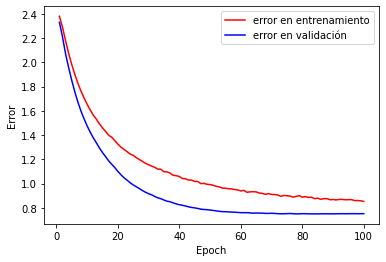

In [24]:
#gráfico sin dropout
train_accuracy = log.history["categorical_accuracy"]
val_accuracy = log.history["val_categorical_accuracy"]
train_error = log.history["loss"]
val_error = log.history["val_loss"]
epochs = range(1,len(train_accuracy)+1)
plt.plot(epochs,train_error,color="red",label="error en entrenamiento")
plt.plot(epochs,val_error,color="blue",label="error en validación")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

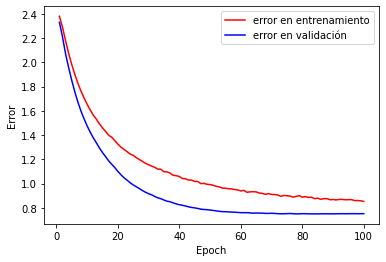

In [25]:
#gráficos con dropout
train_accuracy = log.history["categorical_accuracy"]
val_accuracy = log.history["val_categorical_accuracy"]
train_error = log.history["loss"]
val_error = log.history["val_loss"]
epochs = range(1,len(train_accuracy)+1)
plt.plot(epochs,train_error,color="red",label="error en entrenamiento")
plt.plot(epochs,val_error,color="blue",label="error en validación")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

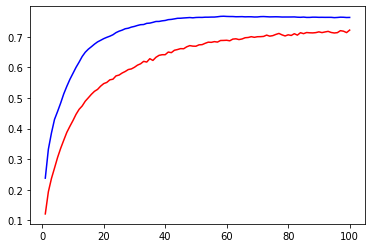

In [26]:
plt.plot(epochs,train_accuracy,color="red",label="accuracy en entrenamiento")
plt.plot(epochs,val_accuracy,color="blue",label="accuracy en validación")

**Ejemplo 2: Incluyendo el Embedding en la Red Convolucional**

In [27]:
(xtrain,ytrain),(xtest,ytest) = ke.datasets.imdb.load_data(num_words=5000,seed=777)

17473536/17464789 [==============================] - 1s 0us/step


In [28]:
r = [len(xtrain[i]) for i in range(len(xtrain))]
print(min(r),max(r))

11 2494


In [31]:
#hacemos que sean del mismo tamaño todos los comentarios (hacer un padding)
Xtrain = ke.preprocessing.sequence.pad_sequences(xtrain, maxlen=500)
Xtest =  ke.preprocessing.sequence.pad_sequences(xtest, maxlen=500)

In [32]:
modelo = ke.models.Sequential()
modelo.add(ke.layers.Embedding(5000,300,input_length=500) )
modelo.add(ke.layers.Conv1D(100,3,padding="same",activation="relu"))
modelo.add(ke.layers.MaxPooling1D(pool_size=2))
modelo.add(ke.layers.Flatten())
modelo.add(ke.layers.Dense(50,activation="relu"))
modelo.add(ke.layers.Dropout(0.3))
modelo.add(ke.layers.Dense(1,activation="sigmoid"))
modelo.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          1500000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 100)          90100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1250050   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [33]:
#100*3*300+100 = 90100

In [34]:
log = modelo.fit(Xtrain,ytrain,validation_data=(Xtest,ytest),epochs=5,batch_size=500)

Epoch 1/5
50/50 [==============================] - 12s 210ms/step - loss: 0.6552 - accuracy: 0.5930 - val_loss: 0.4486 - val_accuracy: 0.7957
Epoch 2/5
50/50 [==============================] - 10s 208ms/step - loss: 0.3236 - accuracy: 0.8703 - val_loss: 0.3140 - val_accuracy: 0.8661
Epoch 3/5
50/50 [==============================] - 10s 207ms/step - loss: 0.2270 - accuracy: 0.9164 - val_loss: 0.2779 - val_accuracy: 0.8837
Epoch 4/5
50/50 [==============================] - 10s 207ms/step - loss: 0.1753 - accuracy: 0.9374 - val_loss: 0.3064 - val_accuracy: 0.8803
Epoch 5/5
50/50 [==============================] - 10s 204ms/step - loss: 0.1425 - accuracy: 0.9550 - val_loss: 0.3401 - val_accuracy: 0.8761


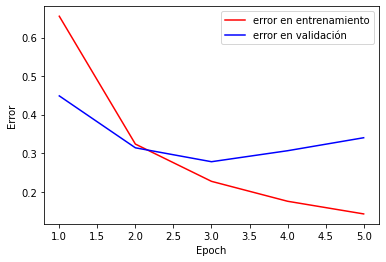

In [35]:
train_accuracy = log.history["accuracy"]
val_accuracy = log.history["val_accuracy"]
train_error = log.history["loss"]
val_error = log.history["val_loss"]
epochs = range(1,len(train_accuracy)+1)
plt.plot(epochs,train_error,color="red",label="error en entrenamiento")
plt.plot(epochs,val_error,color="blue",label="error en validación")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()